# Load Data

In [168]:
import sys
import time
import collections
import numpy as np

In [2]:
with open('../021 Sentiment Analysis - Trask/reviews.txt','r') as f:
    reviews = list(map(str.strip, f.readlines()))

In [3]:
counter_all = collections.Counter()  # how many times each word occurs is whole dataset 
for review in reviews:
    for word in review.split():
        counter_all[word] += 1

In [4]:
review_vocab = set(counter_all.keys())
review_vocab_size = len(review_vocab)
print(review_vocab_size)

74073


In [5]:
word2index = {}
index2word = {}
for i, word in enumerate(review_vocab):
    word2index[word] = i
    index2word[i] = word

In [6]:
def review_to_indices(review):
    res = []
    for word in review.split():
        res.append(word2index[word])
    return np.array(res)

In [7]:
inputs = []
targets = []
for review in reviews:
    review_as_ints = review_to_indices(review)
    for i in range(2, len(review_as_ints)-2):
        inputs.append(review_as_ints[[i-2, i-1, i+1, i+2]])
        targets.append(review_as_ints[i])
inputs = np.array(inputs)
targets = np.expand_dims(targets, -1)  # ok

In [8]:
n_rev = 10
n_word = 12

# find location
print('chunk:  ', ' '.join(reviews[n_rev].split()[n_word-2:n_word+3]))

# find index in target array
lens = np.array([len(x.split()) for x in reviews])
ii = np.sum(lens[0:n_rev]-4) + n_word-2

print('inputs: ', index2word[inputs[ii, 0]],
                 index2word[inputs[ii, 1]],
                 '      ',
                 index2word[inputs[ii, 2]],
                 index2word[inputs[ii, 3]])
print('target:            ', index2word[targets[ii, 0]])

chunk:   the quirky insane robin williams
inputs:  the quirky        robin williams
target:             insane


# Neural Network

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1-sigmoid(x))

In [10]:
def forward(xi, yi, Wh, Wo):
    """Params:
        xi - indices [1234, 2345, ... ]
        yi - indices [9876, 8765, ... ] - target words, including correct target
    """
    assert xi.ndim == 1
    assert yi.ndim == 1
    
    z_hid = np.sum(Wh[xi], axis=0, keepdims=True)
    # do not do hidden activation
    z_out = z_hid @ Wo[:,yi]
    y_hat = sigmoid(z_out)
    
    return y_hat, z_out, z_hid

In [62]:
def backward(xi, yi, y, Wh, Wo, lr, mode='apply_gradient'):
    """Params:
        xi - indices [1234, 2345]
    """
    assert xi.ndim == 1
    assert yi.ndim == 1
    assert y.ndim == 2
    
    y_hat, z_out, z_hid = forward(xi, yi, Wh, Wo)
    
    ro_out = -(y-y_hat) * sigmoid_deriv(z_out)  # scalar
    del_Wo_i = np.dot(z_hid.T, ro_out)
    # Wo[:,yi] += -lr * del_Wo_i
    
    ro_hid = np.dot(ro_out, Wo[:,yi].T)      # 1 x hid_n
        
    # Optional: numerical gradient check
#     xv = np.zeros([1, len(Wh)])           
#     xv[0,xi] = 1
#     del_Wh = np.zeros_like(Wh)
#     del_Wh[xi] = ro_hid
#     ngrad_Wo, ngrad_Wh = ngrad(xv, y, Wh, Wo)
#     if not np.allclose(del_Wo, ngrad_Wo):
#         raise ValueError('Gradient check fail output')
#     if not np.allclose(del_Wh, ngrad_Wh):
#         raise ValueError('Gradient check fail hidden')
#     print('ngrad OK')
        
    if mode == 'apply_gradient': 
        Wh[xi] += -lr * ro_hid
        Wo[:,yi] += -lr * del_Wo_i
        return y_hat
    elif mode == 'return_gradients':
        # This code is required to do numerical gradient checks
        # Efficiency note: 
        # because arrays Wh,Wo are very large this is quite slow
        del_Wh = np.zeros_like(Wh)
        del_Wh[xi] = ro_hid
        del_Wo = np.zeros_like(Wo)
        del_Wo[:,yi] = del_Wo_i
        return del_Wo, del_Wh
    

# Gradient Checks

In [64]:
def forward_vec(xv, Wh, Wo):
    """Params:
        xv - sparse [[0, 0, 1, 0, 1, ...]]
        Wh - weights hidden
        Wo - weights output
    """
    assert xv.ndim == 2
    z_hid = xv @ Wh
    # do not do hidden activation
    z_out = z_hid @ Wo
    y_hat = sigmoid(z_out)
    return y_hat, z_out, z_hid

In [65]:
def loss(xv, y, Wh, Wo):
    y_hat, z_out, z_hid = forward_vec(xv, Wh, Wo)
    return .5 * np.sum((y-y_hat)**2)

In [71]:
def loss(y, y_hat):
    return .5 * np.sum((y-y_hat)**2)

In [82]:
def ngrad(xv, y, Wh, Wo):
    """Params:
    xv - sparse vector [0, 0, 1, 0, 1, 0, ...]
    """
    assert xv.ndim == 2
    assert y.ndim == 2
    
    eps = 1e-4
    
    # numerical gradient check output
    ngrad_Wo = np.zeros_like(Wo)
    for r in range(Wo.shape[0]):
        for c in range(Wo.shape[1]):
            W_min = Wo.copy()
            W_pls = Wo.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            y_hat_pls, _, _ = forward_vec(xv, Wh, W_pls)
            l_pls = loss(y, y_hat_pls)
            y_hat_min, _, _ = forward_vec(xv, Wh, W_min)
            l_min = loss(y, y_hat_min)

            ngrad_Wo[r, c] = (l_pls - l_min) / (eps * 2)
    
    # numerical gradient check hidden
    ngrad_Wh = np.zeros_like(Wh)
    _, idx_nonzero = np.nonzero(xv)
    for r in idx_nonzero: #range(self.weights_0_1.shape[0]):
        for c in range(Wh.shape[1]):
            W_min = Wh.copy()
            W_pls = Wh.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps

            y_hat_pls, _, _ = forward_vec(xv, W_pls, Wo)
            l_pls = loss(y, y_hat_pls)
            y_hat_min, _, _ = forward_vec(xv, W_min, Wo)
            l_min = loss(y, y_hat_min)

            ngrad_Wh[r, c] = (l_pls - l_min) / (eps * 2)
            
    return ngrad_Wo, ngrad_Wh     

In [83]:
N_in = 10
N_hid = 8
N_out = 12
np.random.seed(1)
W_hid = np.random.normal(0, N_in**-.5, [N_in, N_hid])
W_out = np.random.normal(0, N_hid**-.5, [N_hid, N_out])
xx = np.random.randint(0, 2, size=[1, N_in])
yy = np.random.normal(0, 1, [1, N_out])
xi = np.nonzero(xx)[1]
yi = np.array(range(N_out))

In [84]:
print('xx', xx)
print('xi', xi)
print('yy', yy)
print('yi', yi)

xx [[0 1 0 1 1 1 1 1 0 1]]
xi [1 3 4 5 6 7 9]
yy [[ 0.53317198 -0.58513304 -0.56053692  0.14077318  1.76760095 -0.78777374
  -0.06172207  0.23842679  0.07477245  0.33830476  0.27807663  1.22396588]]
yi [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [85]:
# Test forward pass against non-index version
np.random.seed(1)

for i in range(10):
    xx = np.random.randint(0, 2, size=[1, N_in])
    xi = np.nonzero(xx)[1]
    yi = np.random.choice(range(N_out), size=5, replace=False)

    y_hat, z_out, z_hid = forward_vec(xx, W_hid, W_out)
    y_hati, z_outi, z_hidi = forward(xi, yi, W_hid, W_out)

    assert np.allclose(y_hat[:,yi], y_hati)
    assert np.allclose(z_out[:,yi], z_outi)
    assert np.allclose(z_hid, z_hidi)
    
    print(np.max(np.abs(y_hat[:,yi]-y_hati)), np.max(np.abs(z_out[:,yi]-z_outi)), np.max(np.abs(z_hid-z_hidi)))

0.0 5.551115123125783e-17 0.0
0.0 5.551115123125783e-17 0.0
5.551115123125783e-17 1.1102230246251565e-16 0.0
5.551115123125783e-17 1.1102230246251565e-16 0.0
0.0 1.1102230246251565e-16 0.0
5.551115123125783e-17 1.6653345369377348e-16 0.0
5.551115123125783e-17 1.1102230246251565e-16 0.0
5.551115123125783e-17 1.1102230246251565e-16 0.0
0.0 1.1102230246251565e-16 0.0
5.551115123125783e-17 1.1102230246251565e-16 0.0


In [86]:
# Test backward pass against non-optimized version
np.random.seed(1)
for i in range(10):

    xx = np.random.randint(0, 2, size=[1, N_in])
    yy = np.random.normal(0, 1, [1, N_out])
    xi = np.nonzero(xx)[1]
    yi = np.random.choice(range(N_out), size=5, replace=False)

    temp_yi = np.random.choice(range(N_out), size=5, replace=False)
    temp_yy = yy[:,temp_yi]

    dWo, dWh = backward(xi, temp_yi, temp_yy, W_hid, W_out, None, mode='return_gradients')

    y_hat, z_out, z_hid = forward_vec(xx, W_hid, W_out)
    y_hat[:,temp_yi] = yy[:,temp_yi]
    ngWo, ngWh = ngrad(xx, y_hat, W_hid, W_out)

    assert np.allclose(ngWo, dWo)
    assert np.allclose(ngWh, dWh)
    
    print(np.max(np.abs(ngWh-dWh)), np.max(np.abs(ngWo-dWo)))

1.9941970297310263e-10 8.94230023362752e-10
9.992788541079989e-11 3.041814022886058e-10
2.3733581766549605e-10 4.022676636239453e-10
4.238850243032388e-11 9.43689570931383e-12
1.7664786300386481e-10 2.0341855977434875e-10
1.0316739129656582e-10 3.1466040883998403e-10
4.986805413054185e-11 3.680737936662126e-10
4.5849102292550015e-11 1.6478229891703222e-10
1.237336344495077e-10 2.739610482915822e-10
1.2854056707922723e-10 1.6746970477043988e-10


# Train

In [189]:
n_rev = 10
n_word = 12

# find location
print('chunk:  ', ' '.join(reviews[n_rev].split()[n_word-2:n_word+3]))

# find index in target array
lens = np.array([len(x.split()) for x in reviews])
ii = np.sum(lens[0:n_rev]-4) + n_word-2

print('inputs: ', index2word[inputs[ii, 0]],
                  index2word[inputs[ii, 1]],
                  '      ',
                  index2word[inputs[ii, 2]],
                  index2word[inputs[ii, 3]])
print('target:            ', index2word[targets[ii, 0]])

chunk:   the quirky insane robin williams
inputs:  the quirky        robin williams
target:             insane


In [218]:
n_rev = 200
n_word = 22

# find location
print('chunk:  ', ' '.join(reviews[n_rev].split()[n_word-2:n_word+3]))

# find index in target array
lens = np.array([len(x.split()) for x in reviews])
ii = np.sum(lens[0:n_rev]-4) + n_word-2

chunk:   an underlying moral excellent portrayals


In [219]:
xi = inputs[ii]

In [220]:
yi = np.array(range(N_out))

In [221]:
y_hat, _, _ = forward(xi, yi, W_hid, W_out)

In [222]:
out_idx = np.argmax(y_hat)

In [223]:
index2word[out_idx]

'artist'

In [225]:
index2word[np.random.randint(N_out)]

'consummately'

In [39]:
yy = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [46]:
yi = np.random.choice(targets.reshape(-1), 6)
yi[0] = targets[idx, 0]

In [60]:
np.concatenate([targets[idx], np.random.choice(targets.reshape(-1), 5)])

array([11687, 24526, 30103, 50228, 41151, 59586])

In [56]:
targets[idx]

array([11687])

In [176]:
N_in = len(review_vocab)
N_hid = 50
N_out = len(review_vocab)
lr = 0.05

In [177]:
def reset_nn():
    global W_hid, W_out
    np.random.seed(1)
    W_hid = np.random.normal(0, N_in**-.5, [N_in, N_hid])
    W_out = np.random.normal(0, N_hid**-.5, [N_hid, N_out])
    
    # Trask
    W_hid = (np.random.rand(len(review_vocab),N_hid) - 0.5) * 0.2
    W_out = np.random.rand(N_hid,len(review_vocab))*0
reset_nn()

In [178]:
np_iterations = len(inputs) * 2

trace_loss = []

start_time = time.time()

for i in range(np_iterations):
    idx = np.random.randint(len(inputs))
    xi = inputs[idx]
    yy = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    yi = np.concatenate([targets[idx], np.random.choice(targets.reshape(-1), 5)])
    #yi = np.random.choice(targets.reshape(-1), 6)
    #yi[0] = targets[idx, 0]
    
    y_hat = backward(xi, yi, yy, W_hid, W_out, lr)
    ll = loss(yy, y_hat)
    
    trace_loss.append(ll)
    
    if i % 100000 == 0:
        
        timespan = time.time() - start_time
        rev_per_sec = i / timespan
            
        print('----')
        print('Iteration:', i, '\tProgress', i/np_iterations, '\tSpeed(rev/sec):', round(rev_per_sec, 0))
        res = np.array(find_similar('terrible'))
        print(res[:,0])
        print(res[:,1])
        
#     if i >= 100000:
#         break
    

----
Iteration: 0 	Progress 0.0 	Speed(rev/sec): 0.0
['terrible' 'cashes' 'enos' 'hospice' 'jewellers' 'ellipsis' 'fulton'
 'dorcas' 'basinger' 'inevitabally']
['-0.0' '-0.3979650897733217' '-0.4017985187769395' '-0.4023314771803556'
 '-0.4057251389113027' '-0.4075648955861062' '-0.40978671632618463'
 '-0.4122422052181818' '-0.4138739419371939' '-0.41593095948175934']
----
Iteration: 100000 	Progress 0.008003344757841197 	Speed(rev/sec): 6421.0
['terrible' 'cashes' 'enos' 'ellipsis' 'commemorated' 'psychoanalytical'
 'fulton' 'empowering' 'shafeek' 'comported']
['-0.0' '-0.383275682681235' '-0.40939140749968755' '-0.41123566753052054'
 '-0.41251926424787533' '-0.422016685299933' '-0.42423834584581743'
 '-0.4247603359254691' '-0.4256809189541494' '-0.42606289747098364']
----
Iteration: 200000 	Progress 0.016006689515682394 	Speed(rev/sec): 6463.0
['terrible' 'commemorated' 'cashes' 'ellipsis' 'empowering' 'signia'
 'bobba' 'yukfest' 'psychoanalytical' 'comported']
['-0.0' '-0.4033451916

----
Iteration: 2100000 	Progress 0.16807023991466513 	Speed(rev/sec): 6487.0
['terrible' 'horrible' 'ridiculous' 'poor' 'brilliant' 'weak' 'hilarious'
 'indeed' 'superb' 'ok']
['-0.0' '-0.6351050378456371' '-0.7498336662865249' '-0.8197855446757188'
 '-0.8273838599199047' '-0.8283051056063107' '-0.8555570339735854'
 '-0.8764629979334378' '-0.8825063620884476' '-0.8900888731386543']
----
Iteration: 2200000 	Progress 0.17607358467250633 	Speed(rev/sec): 6488.0
['terrible' 'horrible' 'ridiculous' 'poor' 'brilliant' 'weak' 'superb'
 'hilarious' 'indeed' 'ok']
['-0.0' '-0.6892404878862308' '-0.7965762735459531' '-0.8656545433483547'
 '-0.8665222234250688' '-0.8812028065994015' '-0.8904015797755562'
 '-0.8907536878664674' '-0.9349374119096259' '-0.9518388126527314']
----
Iteration: 2300000 	Progress 0.18407692943034754 	Speed(rev/sec): 6488.0
['terrible' 'horrible' 'ridiculous' 'brilliant' 'poor' 'hilarious' 'weak'
 'truly' 'superb' 'indeed']
['-0.0' '-0.7000289322221135' '-0.77984545705492

----
Iteration: 4200000 	Progress 0.33614047982933026 	Speed(rev/sec): 6490.0
['terrible' 'horrible' 'poor' 'brilliant' 'ridiculous' 'fantastic'
 'hilarious' 'miscast' 'dull' 'lame']
['-0.0' '-0.8231382237631047' '-0.9652031130616704' '-1.1092186346618347'
 '-1.1202407139811863' '-1.166425628429973' '-1.1743970590134503'
 '-1.214686527273775' '-1.2156073734837158' '-1.2157112742969833']
----
Iteration: 4300000 	Progress 0.34414382458717147 	Speed(rev/sec): 6489.0
['terrible' 'horrible' 'poor' 'brilliant' 'ridiculous' 'fantastic'
 'hilarious' 'miscast' 'superb' 'lame']
['-0.0' '-0.8532884703333757' '-0.969375510758902' '-1.104550338660411'
 '-1.1170111424722038' '-1.1629772081853336' '-1.1685836708887896'
 '-1.2027110523970828' '-1.220551633875291' '-1.226645761496503']
----
Iteration: 4400000 	Progress 0.35214716934501267 	Speed(rev/sec): 6488.0
['terrible' 'horrible' 'poor' 'brilliant' 'hilarious' 'fantastic'
 'ridiculous' 'superb' 'wonderful' 'miscast']
['-0.0' '-0.8588523361909499' 

----
Iteration: 6300000 	Progress 0.5042107197439955 	Speed(rev/sec): 6463.0
['terrible' 'horrible' 'brilliant' 'poor' 'awful' 'ridiculous' 'superb'
 'hilarious' 'lame' 'dull']
['-0.0' '-0.8439552229862037' '-1.290198712217372' '-1.3082230892315898'
 '-1.3383348794709735' '-1.404025090886473' '-1.4180603123643432'
 '-1.4196307487723494' '-1.4409751027911428' '-1.4418741981397356']
----
Iteration: 6400000 	Progress 0.5122140645018366 	Speed(rev/sec): 6463.0
['terrible' 'horrible' 'awful' 'poor' 'brilliant' 'ridiculous' 'lame'
 'dull' 'fantastic' 'hilarious']
['-0.0' '-0.8533463509762431' '-1.3251895575245112' '-1.3324645856385056'
 '-1.3431992518868825' '-1.3943838019865775' '-1.4258253579364664'
 '-1.429405332238199' '-1.4316380370179411' '-1.4404763148662343']
----
Iteration: 6500000 	Progress 0.5202174092596779 	Speed(rev/sec): 6463.0
['terrible' 'horrible' 'awful' 'brilliant' 'poor' 'ridiculous' 'lame'
 'hilarious' 'fantastic' 'dull']
['-0.0' '-0.8752213942976312' '-1.33158755146977

['terrible' 'horrible' 'ridiculous' 'brilliant' 'lame' 'stupid'
 'fantastic' 'poor' 'hilarious' 'superb']
['-0.0' '-0.8515213328213983' '-1.3718491159001078' '-1.37750825055393'
 '-1.427044447740776' '-1.4764863357382805' '-1.4958656432006978'
 '-1.540826071234876' '-1.5489568444612603' '-1.5528647067398254']
----
Iteration: 8500000 	Progress 0.6802843044165018 	Speed(rev/sec): 6457.0
['terrible' 'horrible' 'ridiculous' 'brilliant' 'lame' 'stupid' 'poor'
 'awful' 'fantastic' 'pathetic']
['-0.0' '-0.8661047915712763' '-1.355090825857395' '-1.3772485392136091'
 '-1.4040591720996332' '-1.4702999779763044' '-1.5402362142733947'
 '-1.5408704539907392' '-1.5481840561524742' '-1.5587767662717387']
----
Iteration: 8600000 	Progress 0.6882876491743429 	Speed(rev/sec): 6456.0
['terrible' 'horrible' 'ridiculous' 'lame' 'brilliant' 'stupid' 'awful'
 'poor' 'fantastic' 'pathetic']
['-0.0' '-0.8748149303171365' '-1.3571655372350826' '-1.3875296199615748'
 '-1.3994546604325928' '-1.4643005041014947' 

['terrible' 'horrible' 'lame' 'ridiculous' 'brilliant' 'stupid' 'pathetic'
 'superb' 'poor' 'fantastic']
['-0.0' '-0.8682727306637279' '-1.4032762383808075' '-1.4734848508276823'
 '-1.474281920652971' '-1.552870878653272' '-1.5627441878192836'
 '-1.6307100092168474' '-1.643408534475629' '-1.6531841323096481']
----
Iteration: 10600000 	Progress 0.8483545443311669 	Speed(rev/sec): 6463.0
['terrible' 'horrible' 'lame' 'ridiculous' 'brilliant' 'stupid' 'pathetic'
 'fantastic' 'superb' 'poor']
['-0.0' '-0.851567615104238' '-1.4108606661916467' '-1.468474445242498'
 '-1.492453415615773' '-1.5429279024934786' '-1.5654444230148663'
 '-1.6589645323146762' '-1.6607802320249712' '-1.662671449086342']
----
Iteration: 10700000 	Progress 0.8563578890890081 	Speed(rev/sec): 6464.0
['terrible' 'horrible' 'lame' 'ridiculous' 'brilliant' 'stupid' 'pathetic'
 'fantastic' 'superb' 'laughable']
['-0.0' '-0.8257427288365419' '-1.4219340817640185' '-1.47654275389857'
 '-1.513265428027981' '-1.567699914284138

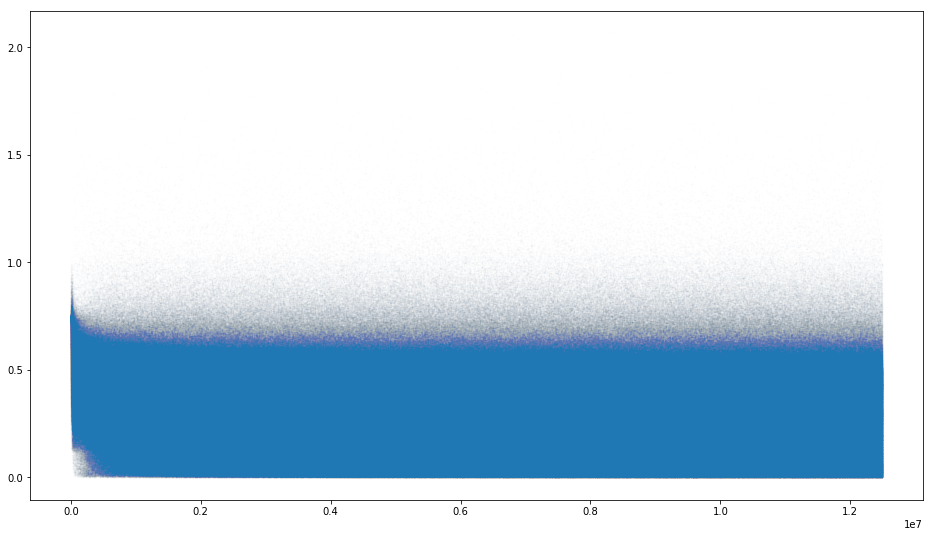

In [179]:
fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(range(len(trace_loss)), trace_loss, alpha=0.01, marker='.', s=1)

# Utility Functions

In [266]:
def find_similar(word):
    embedding = W_hid[word2index[word]]               # target word embedding; shape: (N_hid,) type: float
    norms = np.linalg.norm(embedding-W_hid, axis=-1)  # euclidian disances; shape: (N_words,), type: float
    sorted_similar = np.argsort(norms)                # indices in sorted order; shape: (N_words,), type: int
    return sorted_similar, norms[sorted_similar]

In [275]:
def print_from_indices(indices, how_many):
    result = []
    for i in range(how_many):
        index = indices[i]
        result.append(index2word[index])
    print(' '.join(result))
    

In [286]:
similar, distances = find_similar('terrible')

In [287]:
print_from_indices(similar, 10)
print(np.round(distances[:10], 4))

terrible horrible lame ridiculous pathetic brilliant stupid poor fantastic superb
[0.     0.832  1.5334 1.6141 1.6892 1.6902 1.703  1.713  1.7568 1.7689]


In [ ]:
np.sum(lens[0:n_rev]-4) + n_word-2

In [ ]:
for i, a in enumerate(targets[150:180,0]):
    print(i+150, index2word[a])

In [292]:
word2index['woman']

41468

In [186]:
def analogy(positive=['terrible','good'],negative=['bad']):
    
    norms = np.sum(W_hid * W_hid,axis=1)
    norms.resize(norms.shape[0],1)
    
    normed_weights = W_hid * norms
    
    query_vect = np.zeros(len(W_hid[0]))
    for word in positive:
        query_vect += normed_weights[word2index[word]]
    for word in negative:
        query_vect -= normed_weights[word2index[word]]
    
    scores = collections.Counter()
    for word,index in word2index.items():
        raw_difference = W_hid[index] - query_vect
        squared_difference = raw_difference * raw_difference
        scores[word] = -np.sqrt(sum(squared_difference))
        
    return scores.most_common(10)[1:]

In [296]:
analogy(['actor','woman'],['man'])

[('actress', -36.245925664367405),
 ('role', -36.28162609038512),
 ('cast', -36.431208904809786),
 ('job', -36.79478009899176),
 ('performance', -36.849404408568326),
 ('thing', -37.03143900988384),
 ('actors', -37.063056109887135),
 ('book', -37.12967605815382),
 ('script', -37.16780765438958)]

In [187]:
analogy(['terrible','good'],['bad'])

[('good', -22.059471183785412),
 ('fine', -22.30986295457055),
 ('nice', -22.340945749520493),
 ('wonderful', -22.41481709046441),
 ('superb', -22.502085304061374),
 ('perfect', -22.647190015758888),
 ('fantastic', -22.6557204005291),
 ('decent', -22.680017561311907),
 ('better', -22.76428199559756)]

In [315]:
analogy(['elizabeth','man'],['woman'])

[('writer', -9.808118566062614),
 ('years', -9.849467032650928),
 ('king', -9.86208978917078),
 ('year', -9.868838603911167),
 ('beginning', -9.904394233167247),
 ('theater', -9.978043652553792),
 ('time', -9.980618867766497),
 ('box', -9.985346093708703),
 ('aside', -9.992929256002343)]